In [1]:
import numpy as np
import sys
sys.path.append("../code/")
from structure import *
from algo import *
from basic import *
from analysis import *
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from autograd.numpy import linalg as LA
import pickle
import itertools
from itertools import product
import calendar
from sklearn.metrics import mean_squared_error
%load_ext autoreload
%autoreload 2
import warnings
import seaborn as sns
warnings.filterwarnings("ignore")
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import numpy as np

In [2]:
year = 2015
dataset = 'artificial'
order = APP_NAME_OBSERVED

In [15]:
# load the selected pairs with the best parameter
result = {}
method = 'active'
uncertainty = 'prev_future_weighted'
param = np.load("../data/best-param-{}-active.npy".format(year)).item()
k, latent_dimension, lambda1, lambda2, lambda3, kernel, sigma = param.split("-")

# result['uncertainty'] = {}
for sigma in range(12):
    result[sigma] = get_active_results(year=year, dataset=dataset, method=method, kernel=kernel, sigma=int(sigma),
                                          lambda1=int(lambda1), lambda2=int(lambda2), lambda3=int(lambda3), k=k,
                                          latent_dimension=int(latent_dimension), uncertainty=uncertainty)    

In [42]:
pd.DataFrame(np.load("../data/best-result-2015-qbc.npy").item()).mean(axis=0).mean()

49.41450141105846

In [16]:
error = {}
for e_type in ['overall', 'app']:
    error[e_type] = {}
    for t_type in ['accu', 'month']:
        error[e_type][t_type] = {}
        for k in range(12):
            error[e_type][t_type][k] = {}
            for idx, appliance in enumerate(order[1:]):
                error[e_type][t_type][k][appliance] = {}
                for t in range(12):
                    error[e_type][t_type][k][appliance][t] = {}
                    for random_seed in range(5):
                        error[e_type][t_type][k][appliance][t][random_seed] = {}

In [17]:
tensor, homeidx = get_tensor(year, dataset)
mask_tensor = ~np.isnan(tensor)

In [18]:
for k in range(12):
    for t in range(12):
        # random method
        for idx, appliance in enumerate(order[1:]):
            idx += 1
            for random_seed in range(10):
                # for active method
                predApp = result[k]['prediction'][random_seed][t][:, idx, :] # tensor
                predApp[predApp<0] = 0

                # accumulated appliance error
                appAccuPred = predApp[:, :(t+1)]
#                 print(appliance, appAccuPred.min())
                error['app']['accu'][k][appliance][t][random_seed] = np.sqrt(mean_squared_error(appAccuPred[mask_tensor[:, idx, :(t+1)]], 
                                                                                               tensor[:, idx, :(t+1)][mask_tensor[:, idx, :(t+1)]]))
                # appliance error in current month
                appMonthPred = predApp[:, t]
                error['app']['month'][k][appliance][t][random_seed] = np.sqrt(mean_squared_error(appMonthPred[mask_tensor[:, idx, t]], 
                                                                                                tensor[:, idx, t][mask_tensor[:, idx, t]]))




In [20]:
mean_error = {}

for k in range(12):
    mean_error[k] = {}
    for appliance in order[1:]:
        mean_error[k][appliance] = pd.DataFrame(error['app']['month'][k][appliance]).mean(axis=0)

In [72]:
err = {}

for k in range(12):
    err[k] = pd.DataFrame(mean_error[k]).mean().mean()

Text(0.5,0,'Sigma')

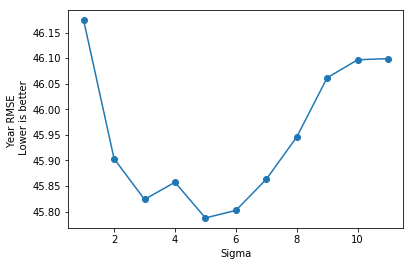

In [35]:
ax = pd.Series(err).plot(marker='o')
ax.set_ylabel("Year RMSE \n Lower is better")
ax.set_xlabel("Sigma")

In [78]:
qbc = [pd.DataFrame(np.load("../data/best-result-2015-qbc.npy").item()).mean(axis=0).mean()] * 12

In [80]:
# pd.Series(qbc).append(pd.Series(err), axis=1)
data = pd.DataFrame({'ALS-Uncertainty': pd.Series(err),'ALS-QBC':pd.Series(qbc)})

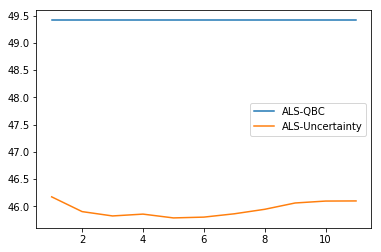

In [84]:
data[1:].plot()